# Create Dataset Subset

In [1]:
0

0

In [2]:
import copy
import gc
import logging
import os
import sys
import warnings

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from scanpy.preprocessing._highly_variable_genes import highly_variable_genes
import tqdm
import scipy
from functools import reduce

sc.settings.verbosity = 3

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [4]:
def deep_memory_usage(obj, seen=None):
    """Recursively estimate memory usage of objects, including sparse arrays."""
    if seen is None:
        seen = set()
    # Avoid duplicate references
    if id(obj) in seen:
        return 0
    seen.add(id(obj))
    size = sys.getsizeof(obj)
    if isinstance(obj, dict):
        size += sum([deep_memory_usage(v, seen) for v in obj.values()])
        size += sum([deep_memory_usage(k, seen) for k in obj.keys()])
    elif isinstance(obj, (list, tuple, set, frozenset)):
        size += sum([deep_memory_usage(i, seen) for i in obj])
    elif isinstance(obj, (pd.DataFrame, pd.Series)):
        size += obj.memory_usage(deep=True).sum()
    elif isinstance(obj, np.ndarray):
        size += obj.nbytes
    elif scipy.sparse.issparse(obj):
        # For sparse matrices, consider the data, indices, and indptr arrays
        size += obj.data.nbytes + obj.indices.nbytes + obj.indptr.nbytes
    # Add other data types if necessary
    return round(size / (1024**2), 2)

__Note that: The unified dataset is prepared for human developmental cell atlas project__

In [5]:
adata_file_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/hdca/"
    "temp/preprocessing/unification_union_20240330_hvg.h5ad"
)
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
display(adata)

AnnData object with n_obs × n_vars = 3623431 × 57009
    obs: 'handle_anndata', 'study', 'sample_ID', 'organ', 'age', 'cell_type', 'lane_ID', 'author_batch', 'institute', 'study_PI', 'doi', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'anatomical_region', 'anatomical_region_level_2', 'sex', 'sex_inferred', 'subject_type', 'sample_status', 'sample_cultured', 'protocol_tissue_dissociation', 'cell_enrichment', 'library_platform', 'strand_sequence', 'sequencing_platform', 'reads_processing', 'biological_unit', 'reference_genome', 'reference_genome_ensembl_release', 'concatenated_integration_covariates'
    var: 'hgnc_Braun', 'hgnc_Calvanese', 'hgnc_Colin', 'hgnc_Dong', 'hgnc_Garcia', 'hgnc_He', 'hgnc_Kanemaru', 'hgnc_Lawrence', 'hgnc_Miller', 'hgnc_Sridhar', 'hgnc_Suo', 'hgnc_To', 'hgnc_Wang', 'hgnc_Yu', 'hgnc_Zhang', 'hgnc', 'intersection', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'hi

In [6]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata)} MB")

Estimated adata memory usage: 149174.7 MB


## Batch Stats

In [7]:
batch_keys = adata.obs["concatenated_integration_covariates"].unique()
batch_stats = list()

GENE_NAME_COLUMN = "hgnc"
NA_CELL_TYPE_PLACEHOLDER = "NA"

for batch_key in tqdm.tqdm(batch_keys):
    adata_batch = adata[adata.obs["concatenated_integration_covariates"] == batch_key, :]
    batch_dataset = list(adata_batch.obs["handle_anndata"].unique())
    assert len(batch_dataset) == 1
    batch_dataset = batch_dataset[0]

    batch_age = list(adata_batch.obs["age"].unique())
    batch_sex = list(adata_batch.obs["sex"].unique())
    batch_organ = list(adata_batch.obs["organ"].unique())
    batch_biological_unit = list(adata_batch.obs["integration_biological_unit"].unique())
    batch_library_platform = list(adata_batch.obs["integration_library_platform_coarse"].unique())
    batch_sample_status = list(adata_batch.obs["integration_sample_status"].unique())

    var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
    adata_batch = adata_batch[:, adata_batch.var[var_column] != NA_CELL_TYPE_PLACEHOLDER]
    cell_sum = adata_batch.X.sum(axis=0).A.flatten()

    n_celltypes = len(adata_batch.obs["cell_type"].unique())
    n_cells, n_genes = adata_batch.X.shape

    batch_stats.append(
        {
            "dataset": batch_dataset,
            "batch_key": batch_key,
            "sex": batch_sex,
            "organ": batch_organ,
            "age": batch_age,
            "library_platform": batch_library_platform,
            "biological_unit": batch_biological_unit,
            "sample_status": batch_sample_status,
            "n_library_platform": len(batch_library_platform),
            "n_biological_unit": len(batch_biological_unit),
            "n_sample_status": len(batch_sample_status),
            "n_sex": len(batch_sex),
            "n_organ": len(batch_organ),
            "n_age": len(batch_age),
            "n_celltypes": n_celltypes,
            "n_cells": n_cells,
            "n_genes": n_genes,
            "cells_per_celltypes": n_cells / n_celltypes,
            "sum": np.sum(cell_sum),
            "mean": np.mean(cell_sum),
            "std": np.std(cell_sum),
            "median": np.median(cell_sum),
        }
    )
batch_stats = pd.DataFrame(batch_stats)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [03:43<00:00,  1.10s/it]


## Training data for `age` experiment

In [8]:
stats_colin = batch_stats[batch_stats["dataset"] == "Colin"].copy()
for i in ['sex', 'organ', 'age', 'library_platform', 'biological_unit', 'sample_status']:
    assert all([len(j) == 1 for j in stats_colin[i]])
    stats_colin[i] = [j[0] for j in stats_colin[i]]
stats_colin = stats_colin.sort_values(by=["sex", "age", "n_cells"], ascending=False).drop_duplicates(["sex", "age"])
stats_colin = stats_colin[~stats_colin["age"].isin([10.0, 16.0, 17.0])]
colin_chosen_batches = list(stats_colin["batch_key"])
stats_colin_chosen = stats_colin[stats_colin["batch_key"].isin(colin_chosen_batches)].copy()
stats_colin_chosen

,dataset,batch_key,sex,organ,age,library_platform,biological_unit,sample_status,n_library_platform,n_biological_unit,...,n_organ,n_age,n_celltypes,n_cells,n_genes,cells_per_celltypes,sum,mean,std,median
45,Colin,donor_3_PCW20_Colin_et_al_Cell_Frozen_3GEX,M,Cornea,20.0,3GEX,Cell,Frozen,1,1,...,1,1,16,7553,20820,472.062500,85938985.0,4127.713016,33857.654259,593.0
38,Colin,donor_4_PCW13_Colin_et_al_Cell_Frozen_3GEX,M,Cornea,13.0,3GEX,Cell,Frozen,1,1,...,1,1,14,5525,20820,394.642857,79464637.0,3816.745293,33878.817705,471.5
32,Colin,donor_2_PCW12_Colin_et_al_Cell_Frozen_3GEX,M,Cornea,12.0,3GEX,Cell,Frozen,1,1,...,1,1,14,8353,20820,596.642857,73586486.0,3534.413353,30354.904459,350.0
44,Colin,donor_2_PCW20_Colin_et_al_Cell_Frozen_3GEX,F,Cornea,20.0,3GEX,Cell,Frozen,1,1,...,1,1,16,11162,20820,697.625000,95312510.0,4577.930355,40472.422785,586.0
35,Colin,donor_1_PCW13_Colin_et_al_Cell_Frozen_3GEX,F,Cornea,13.0,3GEX,Cell,Frozen,1,1,...,1,1,14,7289,20820,520.642857,60013121.0,2882.474592,26205.979552,296.0
31,Colin,donor_1_PCW12_Colin_et_al_Cell_Frozen_3GEX,F,Cornea,12.0,3GEX,Cell,Frozen,1,1,...,1,1,14,8117,20820,579.785714,66024248.0,3171.193468,30533.871868,318.0


In [9]:
stats_colin_chosen.groupby('age').agg(Size=('age', 'size'), Sum=('n_cells', 'sum')), stats_colin_chosen.groupby('sex').agg(Size=('sex', 'size'), Sum=('n_cells', 'sum')), 

(      Size    Sum
 age              
 12.0     2  16470
 13.0     2  12814
 20.0     2  18715,
      Size    Sum
 sex             
 F       3  26568
 M       3  21431)

In [10]:
adata_dataset_1 = adata[adata.obs["concatenated_integration_covariates"].isin(colin_chosen_batches)]
batch_dataset = adata_dataset_1.obs["handle_anndata"].unique()[0]
var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var[var_column] != NA_CELL_TYPE_PLACEHOLDER].copy()
adata_dataset_1.shape

(47999, 20820)

In [11]:
min_cell_count = 100
batches_cell_type = list()
for batch_key in colin_chosen_batches:
    batch_adata_obs = adata_dataset_1.obs[adata_dataset_1.obs["concatenated_integration_covariates"] == batch_key]
    batch_cell_type_vc = batch_adata_obs["cell_type"].value_counts()
    batch_cell_type = set(batch_cell_type_vc[batch_cell_type_vc > min_cell_count].index)
    batches_cell_type.append(batch_cell_type)
chosen_cell_types = reduce(set.intersection, batches_cell_type)
adata_dataset_1 = adata_dataset_1[adata_dataset_1.obs["cell_type"].isin(chosen_cell_types), :].copy()
adata_dataset_1.shape, len(chosen_cell_types)

((27159, 20820), 4)

In [12]:
adata_dataset_1.obs.groupby(["age", "sex"]).size()

age   sex
12.0  F      5577
      M      5910
13.0  F      2920
      M      2610
20.0  F      6777
      M      3365
dtype: int64

In [13]:
# remove cell-cycle, bcr, tcr. Also, scanpy filter genes
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var["highly_variable_omitted_reason"] == "NA"].copy()
del adata_dataset_1.var
gc.collect()
adata_dataset_1.shape

(27159, 20296)

In [14]:
adata_dataset_1.layers["counts"] = adata_dataset_1.X.copy()
sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)

normalizing counts per cell
    finished (0:00:00)


In [15]:
# Calculate dispersion and mean with scanpy function to determine max and min means.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    highly_variable_genes(
        adata=adata_dataset_1, 
        layer=None, 
        batch_key="concatenated_integration_covariates", 
        subset=False, 
        inplace=True
    )
    adata_dataset_1.var.drop(columns=["highly_variable"], inplace=True)
adata_dataset_1_var_before = adata_dataset_1.var.copy()
gc.collect();

extracting highly variable genes
    finished (0:00:13)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [16]:
hvg_dict = dict(
    hvg_number=2**12, 
    min_mean=0.05, 
    max_mean=3
)

Filter-in:  12781
Filter-out: 7515


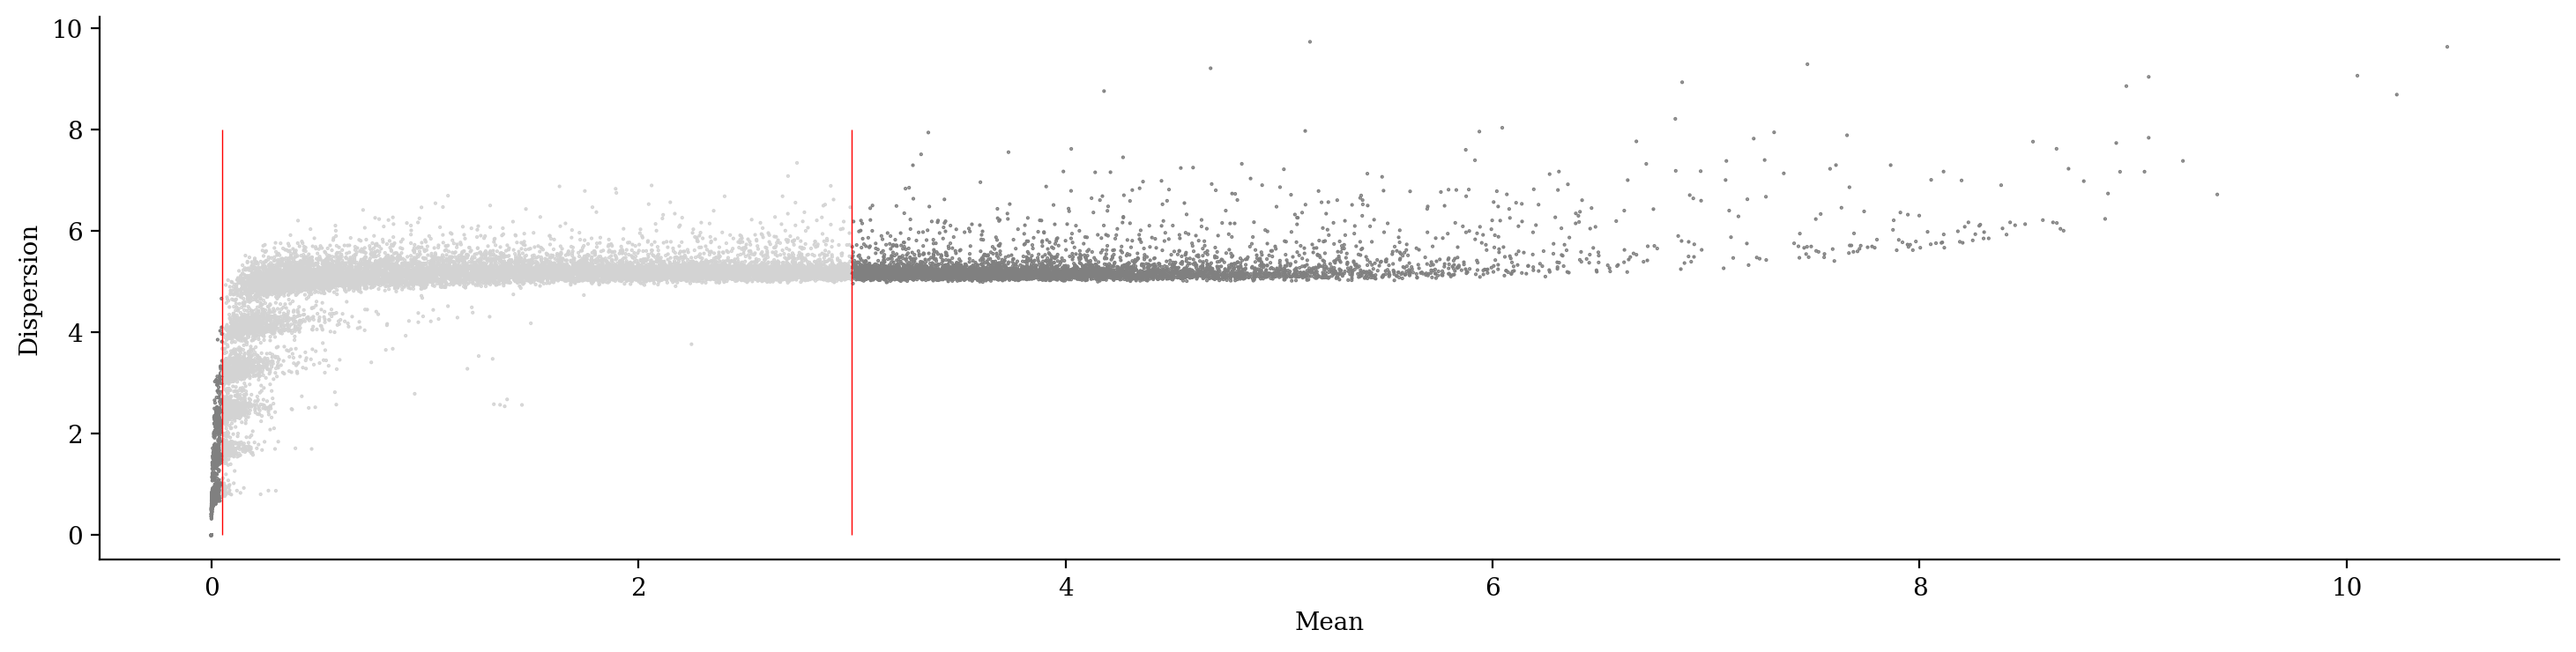

In [17]:
# Visualize the effect of thresholds.
filter_in = np.logical_and.reduce(
    (adata_dataset_1_var_before["means"] > (hvg_dict["min_mean"] if hvg_dict["min_mean"] is not None else -np.inf), 
     adata_dataset_1_var_before["means"] < (hvg_dict["max_mean"] if hvg_dict["max_mean"] is not None else np.inf)
    )
)
print(f"Filter-in:  {np.sum(filter_in)}")
print(f"Filter-out: {len(adata_dataset_1_var_before) - np.sum(filter_in)}")

boolean_to_color = {True: "lightgray", False: "gray"}
hvg_colors = pd.Series(filter_in).map(boolean_to_color)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [18]:
def select_hvgs(adata_var, top_gene_number, min_mean, max_mean):
    assert not np.isnan(adata_var["means"]).any(), "There are `nan`s in the HVG."
    
    count_removed = 0
    if isinstance(min_mean, int) or isinstance(min_mean, float):
        _mim = min_mean < adata_var["means"]
        count_removed += np.sum(~_mim)
        adata_var = adata_var[_mim]
    else:
        assert min_mean is None
        
    if isinstance(max_mean, int) or isinstance(max_mean, float):
        _mam = adata_var["means"] < max_mean
        count_removed += np.sum(~_mam)
        adata_var = adata_var[_mam]
    else:
        assert max_mean is None
        
    passed_thresholding = adata_var.index.copy()
    
    # sort genes by how often they selected as hvg within each batch and
    # break ties with normalized dispersion across batches. as the original function does.
    adata_var["dispersions_norm"] = adata_var["dispersions_norm"].astype("float32")
    if "highly_variable_nbatches" in adata_var.columns:        
        adata_var.sort_values(
            ['highly_variable_nbatches', 'dispersions_norm'],
            ascending=False,
            na_position='last',
            inplace=True,
            ignore_index=False
        )
    else:
        warnings.warn("`highly_variable_nbatches` is not found. Only `dispersions_norm` will be used.")
        adata_var.sort_values(
            ['dispersions_norm'],
            ascending=False,
            na_position='last',
            inplace=True,
            ignore_index=False
        )
    
    if top_gene_number is None:
        top_gene_number = len(adata_var)
    elif len(adata_var) < top_gene_number:
        warnings.warn(
            f"Queried HVG gene count is lower than `{len(adata_var)}`. "
            f"Note: min-max (and np.nan values) filtered out: {count_removed}"
        )
        top_gene_number = len(adata_var)

    adata_var_sorted_index = adata_var.index.copy()

    adata_var = adata_var[:top_gene_number]
    assert np.sum(np.isnan(adata_var["dispersions_norm"])) == 0, "Unexpected error."
    final_hvg_selection = adata_var.index.copy()

    return set(passed_thresholding), set(final_hvg_selection), adata_var_sorted_index

In [19]:
_, final_hvg_selection, _ = select_hvgs(
    adata_var=adata_dataset_1.var.copy(),
    top_gene_number=hvg_dict["hvg_number"],
    min_mean=hvg_dict["min_mean"],
    max_mean=hvg_dict["max_mean"],
)

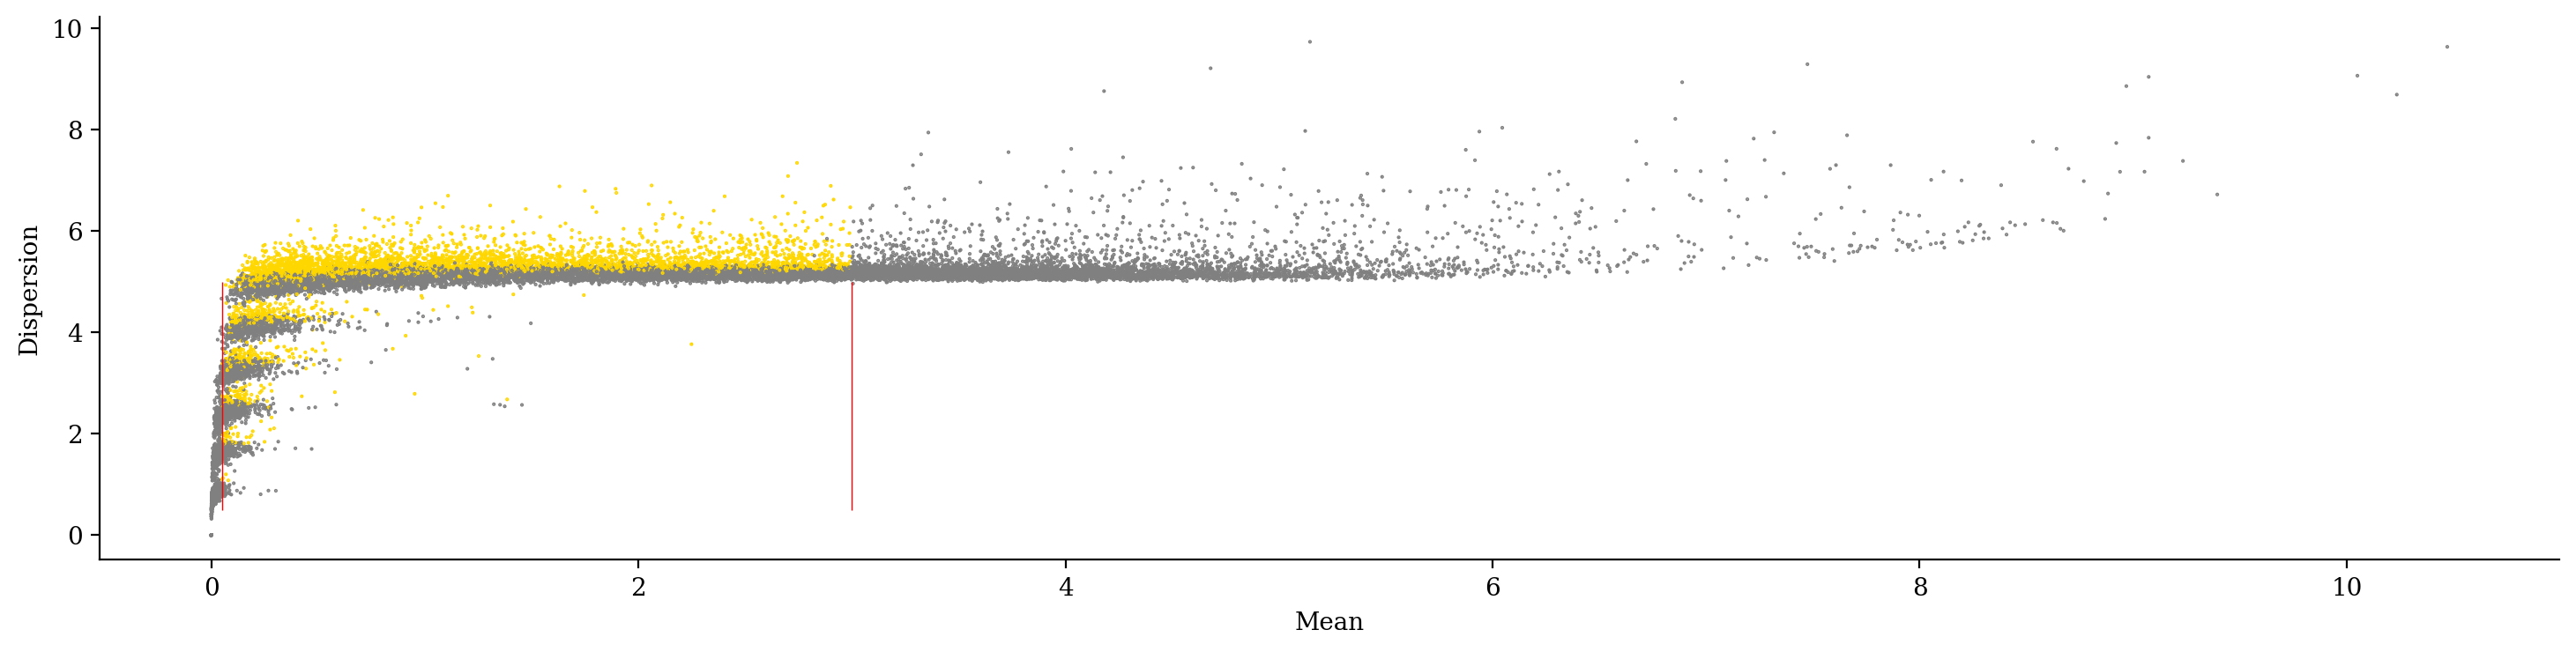

In [20]:
boolean_to_color = {True: "gold", False: "gray"}
chosen_highly_variables = adata_dataset_1_var_before.index.isin(final_hvg_selection)
hvg_colors = pd.Series(chosen_highly_variables).map(
    boolean_to_color
)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [21]:
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var.index.isin(final_hvg_selection)]
adata_dataset_1.shape

(27159, 4096)

In [22]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")
adata_dataset_1.X = adata_dataset_1.layers["counts"].copy()
del adata_dataset_1.layers
gc.collect()
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

Estimated adata memory usage: 79.87 MB
Estimated adata memory usage: 42.4 MB


## Save the resulting subset

In [23]:
write_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/"
    "dataset_subset_age_sex_1.h5ad"
)
adata_dataset_1.write_h5ad(write_path)

In [25]:
1

1